<font size=6><b>고객 성향 분석(Onlie Retail)

<img src="./logo.png"><br>
* ref : https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
* ref : https://archive.ics.uci.edu/ml/datasets/online+retail#

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

# Data Load

## InvoiceDate
* 날짜 타입 변환

In [3]:
df = pd.read_csv("./online_retail.csv", parse_dates=['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [4]:
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


# EDA

## Customer ID 
* 결측

In [5]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

243007, 1067371, 0.23%


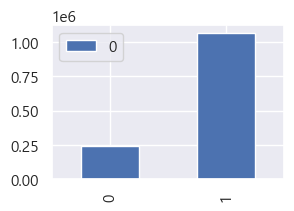

In [6]:
print(f"{df['Customer ID'].isna().sum()}, {df.shape[0]}, {df['Customer ID'].isna().sum()/df.shape[0]:.2f}%")
pd.DataFrame([df['Customer ID'].isna().sum(), df.shape[0]]).plot(kind='bar',figsize=(3,2))
plt.show()

In [7]:
idx = df[df['Customer ID'].isna()].index
print(df.shape)
print(idx[:5])
df = df.drop(idx, axis=0)
df['Customer ID'] = df['Customer ID'].astype('int')
print(df.shape)
df = df.reset_index(drop=True)

(1067371, 8)
Int64Index([263, 283, 284, 470, 577], dtype='int64')
(824364, 8)


## Invoice

In [8]:
df['Invoice'].str.extract(r'([^0-9])').value_counts()

C    18744
dtype: int64

In [9]:
df[df['Invoice'].str.contains('C')].head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia


In [10]:
df['Invoice'] = df['Invoice'].str.extract(r"(\d+)").astype('int64') 

In [11]:
df.loc[178]

Invoice                          489449
StockCode                         22087
Description    PAPER BUNTING WHITE LACE
Quantity                            -12
InvoiceDate         2009-12-01 10:33:00
Price                              2.95
Customer ID                       16321
Country                       Australia
Name: 178, dtype: object

## StockCode

In [12]:
df[['StockCode','Description']].value_counts()

StockCode  Description                       
85123A     WHITE HANGING HEART T-LIGHT HOLDER    5315
22423      REGENCY CAKESTAND 3 TIER              3777
84879      ASSORTED COLOUR BIRD ORNAMENT         2794
85099B     JUMBO BAG RED RETROSPOT               2776
20727      LUNCH BAG  BLACK SKULL.               2161
                                                 ... 
84206B     CAT WITH SUNGLASSES BLANK CARD           1
37432      MUG PINK AND PURPLE ARABIC DESIGN        1
84250M     GREETING CARD, BLACKPOOL ROCK            1
37408      ASSORTED DESIGN GEISHA GIRL MUGS         1
TEST002    This is a test product.                  1
Length: 5331, dtype: int64

In [13]:
df['StockCode'].str.extract(r'([^0-9])').value_counts()

B    26423
A    22458
C    11156
D     6693
L     4427
E     3906
P     3787
F     3413
S     3291
G     2828
M     1861
N     1168
W      984
K      702
H      420
U      385
J      351
R      150
V       63
T       39
I       23
O       13
Y        5
Z        5
dtype: int64

In [14]:
df['StockCode'].value_counts()

85123A    5322
22423     3777
85099B    3446
84879     2794
20725     2755
          ... 
21766        1
37477C       1
20939        1
72751C       1
90011E       1
Name: StockCode, Length: 4646, dtype: int64

## Country
* United Kingdom만 사용

In [15]:
df['Country'].value_counts()

United Kingdom          741301
Germany                  17624
EIRE                     16195
France                   14202
Netherlands               5140
Spain                     3811
Belgium                   3123
Switzerland               3064
Portugal                  2504
Australia                 1913
Channel Islands           1664
Italy                     1534
Norway                    1455
Sweden                    1345
Cyprus                    1176
Finland                   1049
Austria                    938
Denmark                    817
Greece                     663
Japan                      582
USA                        535
Poland                     535
Unspecified                524
United Arab Emirates       386
Singapore                  346
Israel                     324
Malta                      299
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        123
Brazil                      94
Thailand

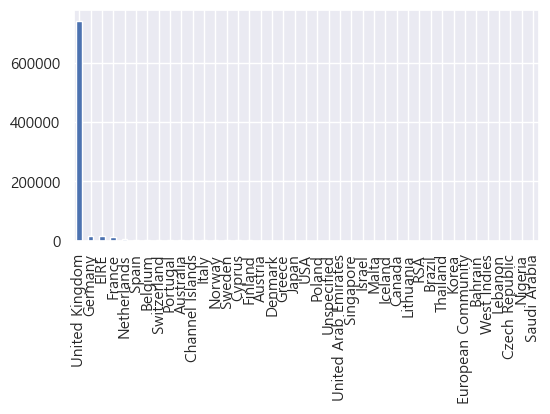

In [16]:
df['Country'].value_counts().plot(kind='bar', figsize=(6,3))
plt.show()

In [17]:
df = df[df['Country'] == 'United Kingdom'].copy()
df = df.reset_index(drop=True)
df['Country'].value_counts()

United Kingdom    741301
Name: Country, dtype: int64

In [18]:
df.describe()

,Invoice,Quantity,Price,Customer ID
count,741301.000000,741301.000000,741301.000000,741301.000000
mean,537107.980040,11.268705,3.459329,15554.046300
std,26735.228725,190.347079,69.683407,1594.076188
min,489434.000000,-80995.000000,0.000000,12346.000000
25%,514487.000000,2.000000,1.250000,14203.000000
50%,536670.000000,4.000000,1.950000,15551.000000
75%,561125.000000,12.000000,3.750000,16936.000000
max,581586.000000,80995.000000,38970.000000,18287.000000


## Quantity
* 수량 (-)  삭제

In [19]:
idx = df[df['Quantity'] < 0].index
print(df.shape)
df = df.drop(idx, axis=0)
df = df.reset_index(drop=True)
print(df.shape)

(741301, 8)
(725296, 8)


## Price
* 금액 0 삭제

In [20]:
idx = df[df['Price'] <= 0].index
print(df.shape)
df = df.drop(idx, axis=0)
df = df.reset_index(drop=True)
print(df.shape)

(725296, 8)
(725250, 8)


# RFM 
* ref : https://ko.wikipedia.org/wiki/RFM
* 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법
* 마케팅에서 가장 많이 사용되고 있는 분석방법 중 하나
* 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석방법
    * <b>Recency - 거래의 최근성: 고객이 얼마나 최근에 구입했는가?
    * <b>Frequency - 거래빈도: 고객이 얼마나 빈번하게 우리 상품을 구입했나?
    * <b>Monetary - 거래규모: 고객이 구입했던 총 금액은 어느 정도인가?

In [21]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

## R (Recency) : 최근 (InvoiceDate)

In [22]:
df['InvoiceDate'].min(),  df['InvoiceDate'].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:49:00'))

In [23]:
# df['day_diff'] = (df['InvoiceDate'].max() - df['InvoiceDate']) + 1
df['day_diff'] = df['InvoiceDate'].max() - df['InvoiceDate']
df['day_diff'] = df['day_diff'].apply(lambda x : x.days+1)
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,day_diff
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,739
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,739


In [24]:
df[df['InvoiceDate'] == df['InvoiceDate'].max()].head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,day_diff
725246,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,1


In [25]:
df = df.set_index('InvoiceDate')
df.head(1)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,day_diff
InvoiceDate,,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085,United Kingdom,739


## F (Frequency) : 빈도 (Invoice, StockCode)

In [26]:
df[['Invoice','StockCode']].value_counts().head()

Invoice  StockCode
555524   22698        20
         22697        12
537224   70007        10
537646   22585        10
536412   21448        10
dtype: int64

## M (Monetary) : 수량 ( Quantity*UnitPrice)

In [27]:
df['monetary'] = df['Quantity'] * df['Price']

In [28]:
df.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,day_diff,monetary
InvoiceDate,,,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085,United Kingdom,739,83.4
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085,United Kingdom,739,81.0
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085,United Kingdom,739,81.0
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085,United Kingdom,739,100.8
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085,United Kingdom,739,30.0


# Customer ID 별  RFM 분석
* R(최근) : day_diff : max
* F(빈도) : InvoiceNo, CustomerID : count
* M(금액) : monetary : sum

* 방법1)

In [29]:
R = pd.DataFrame(df.groupby('Customer ID')['day_diff'].max())
F = pd.DataFrame(df.groupby(df['Customer ID'])['Invoice'].count())
M = pd.DataFrame(df.groupby(df['Customer ID'])['monetary'].sum())
rfm = pd.concat([R,F,M],axis=1)
rfm.columns=['Recency','Frequency','Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,726,34,77556.46
12608,405,16,415.79
12745,574,22,723.85
12746,541,17,254.55
12747,732,257,9276.54


* 방법2)

In [30]:
rfm = df.groupby('Customer ID').agg({'day_diff': 'max', 
                                    'Invoice': 'count', 
                                    'monetary': 'sum'})
rfm.columns = ['R','F','M']
rfm.head()

,R,F,M
Customer ID,,,
12346,726,34,77556.46
12608,405,16,415.79
12745,574,22,723.85
12746,541,17,254.55
12747,732,257,9276.54


In [31]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5350 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       5350 non-null   int64  
 1   F       5350 non-null   int64  
 2   M       5350 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 167.2 KB


In [32]:
rfm.describe()

,R,F,M
count,5350.000000,5350.000000,5350.000000
mean,479.158318,135.560748,2751.990190
std,222.155238,326.055839,12080.466564
min,1.000000,1.000000,2.950000
25%,331.000000,20.000000,336.167500
50%,540.000000,53.000000,849.910000
75%,670.000000,142.000000,2214.905000
max,739.000000,12890.000000,608821.650000


<Figure size 1200x300 with 0 Axes>

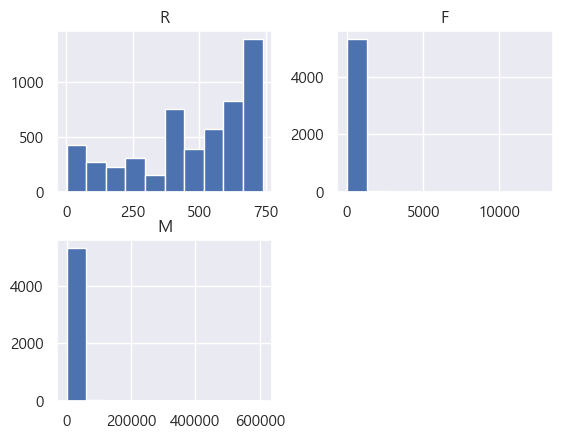

In [33]:
plt.figure(figsize=(12,3))
rfm.hist()
plt.show()

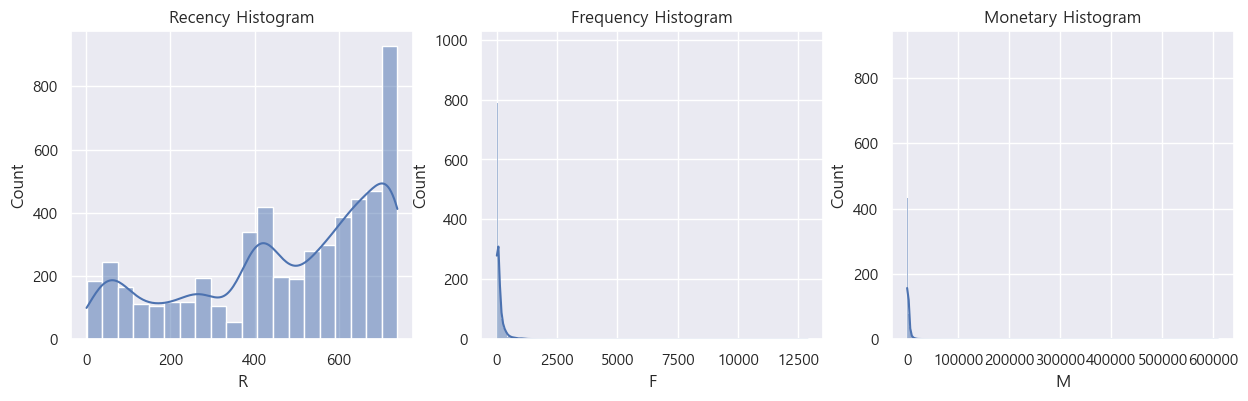

In [34]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

sns.histplot(rfm['R'], kde=True, ax=axs[0])
axs[0].set_title('Recency Histogram')

sns.histplot(rfm['F'], kde=True, ax=axs[1])
axs[1].set_title('Frequency Histogram')

sns.histplot(rfm['M'], kde=True, ax=axs[2])
axs[2].set_title('Monetary Histogram')

plt.show()

## 공통함수

### 시각화

In [35]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

    
def my_chart(cluster_lists, X): 
    
    fig, axs = plt.subplots(figsize=(4*len(cluster_lists), 4), 
                            nrows=1, 
                            ncols=len(cluster_lists))

    for ind, k in enumerate(cluster_lists):
        
        kmeans = KMeans(n_clusters = k , 
                           max_iter=500, random_state=0)
        cluster_labels = kmeans.fit_predict(X)

        sil_coef_mean = silhouette_score(X, cluster_labels)
        sil_coef      = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(k)+'\n' \
                          'Silhouette Score :' + str(round(sil_coef_mean,3)) )
        axs[ind].set_xlabel("silhouette coefficient")
        axs[ind].set_ylabel("cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X) + (k + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 막대 그래프
        for i in range(k):
            ith_cluster_sil_coef = sil_coef[cluster_labels==i]
            ith_cluster_sil_coef.sort()

            size_cluster_i = ith_cluster_sil_coef.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_coef, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_coef_mean, color="red", linestyle="--")
# my_chart([2,3,4,5], X_test)

### 모델학습

In [36]:
def my_clustering(X, cluster_list=[2,3,4,5,6]):
    
    #------차원축소(PCA)------ 
    pca = PCA(n_components=2, random_state=1234)
    pca_X = pca.fit_transform(X)  #원본, StandardScaler, LogScaler
    print(f"explained_variance_ratio_ : {pca.explained_variance_ratio_} {pca.explained_variance_ratio_.sum():.2f}")
    #pca_X = pd.DataFrame(pca_X, columns=['pc1','pc2'])
    
    fig, axes = plt.subplots(figsize=(4*len(cluster_list), 4), 
                            nrows=1, 
                            ncols=len(cluster_list)+1)
    
    inertia_list = []
    for i, k in enumerate(cluster_list):
        #------KMeans군집화------ 
        model = KMeans(n_clusters=k, random_state=1234)
        model.fit(pca_X)
        pred = model.predict(pca_X)  #cluster_label
        
        sil_coef_mean = silhouette_score(X, pred)
        sil_coef      = silhouette_samples(X, pred)
        print(f"{k} 실루엣 점수: {sil_coef_mean:.5f}")
        #pca_X['pred_cluster_label'] = pred
        
        #------스케터차트------ 
        # sns.scatterplot(x=pca_X.iloc[:,0], y=pca_X.iloc[:,1], hue=pred, ax=axes[i])
        sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=pred, ax=axes[i])
        axes[i].set_title(f"Cluster: {k} \n Silhouette Score: {sil_coef_mean:.5f}" )
        
        
        #------엘보차트------
        print(f"{k} inertia_ : {model.inertia_:.5f}")
        inertia_list.append(model.inertia_)
        print("--"*30)
     
    axes[5].plot(cluster_list, np.array(inertia_list))  
    plt.show()
    
    #return pca_X

explained_variance_ratio_ : [9.99034369e-01 6.53508296e-04] 1.00
2 실루엣 점수: 0.98068
2 inertia_ : 369684848129.20636
------------------------------------------------------------
3 실루엣 점수: 0.96471
3 inertia_ : 149731651476.62463
------------------------------------------------------------
4 실루엣 점수: 0.92619
4 inertia_ : 82424886881.05310
------------------------------------------------------------
5 실루엣 점수: 0.82365
5 inertia_ : 46629539496.78485
------------------------------------------------------------
6 실루엣 점수: 0.81448
6 inertia_ : 33300732481.20792
------------------------------------------------------------


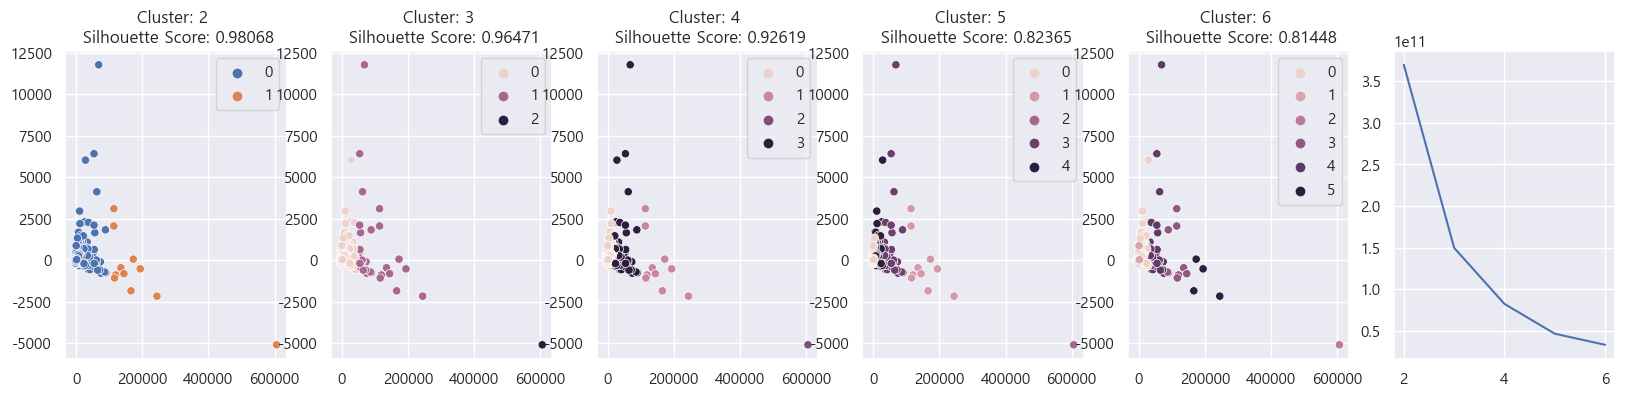

array([[ 7.48003749e+04, -7.88231179e+02],
       [-2.33742885e+03, -1.10365912e+02],
       [-2.02889516e+03, -6.75423578e+01],
       ...,
       [-2.32560511e+03, -5.36570917e+01],
       [-1.45552596e+03,  6.01578598e+00],
       [ 1.43135305e+03,  2.65886194e+01]])

In [37]:
my_clustering(rfm)

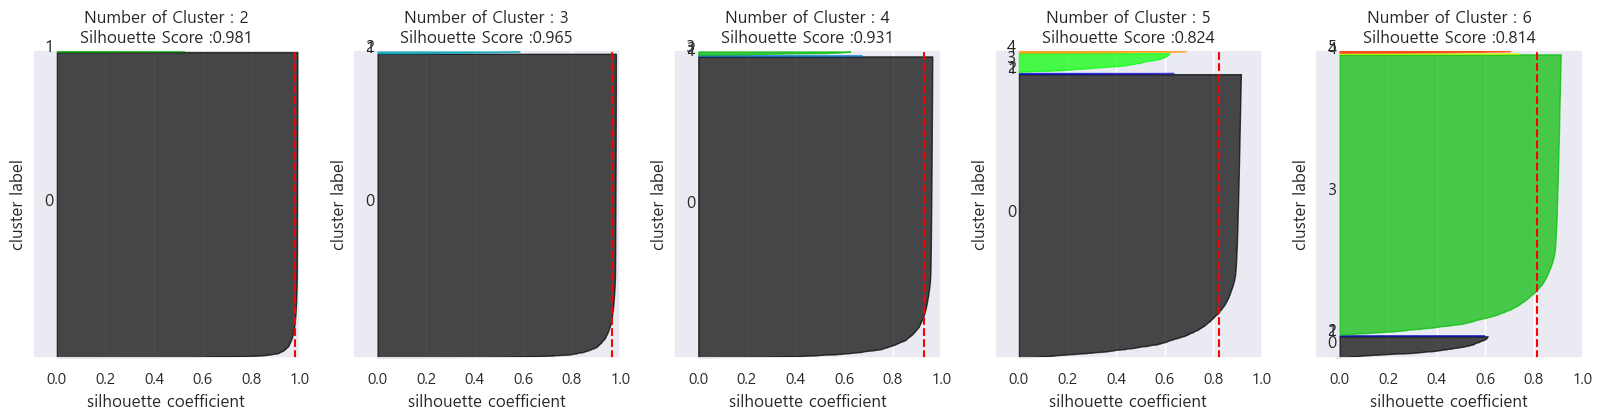

In [38]:
my_chart([2,3,4,5,6], rfm)

## Scaler

### StandardScaler()

explained_variance_ratio_ : [0.49445805 0.29443726] 0.79
2 실루엣 점수: 0.47243
2 inertia_ : 8486.24078
------------------------------------------------------------
3 실루엣 점수: 0.49222
3 inertia_ : 4692.04521
------------------------------------------------------------
4 실루엣 점수: 0.51544
4 inertia_ : 3327.93547
------------------------------------------------------------
5 실루엣 점수: 0.46859
5 inertia_ : 2457.17312
------------------------------------------------------------
6 실루엣 점수: 0.47706
6 inertia_ : 1634.54638
------------------------------------------------------------


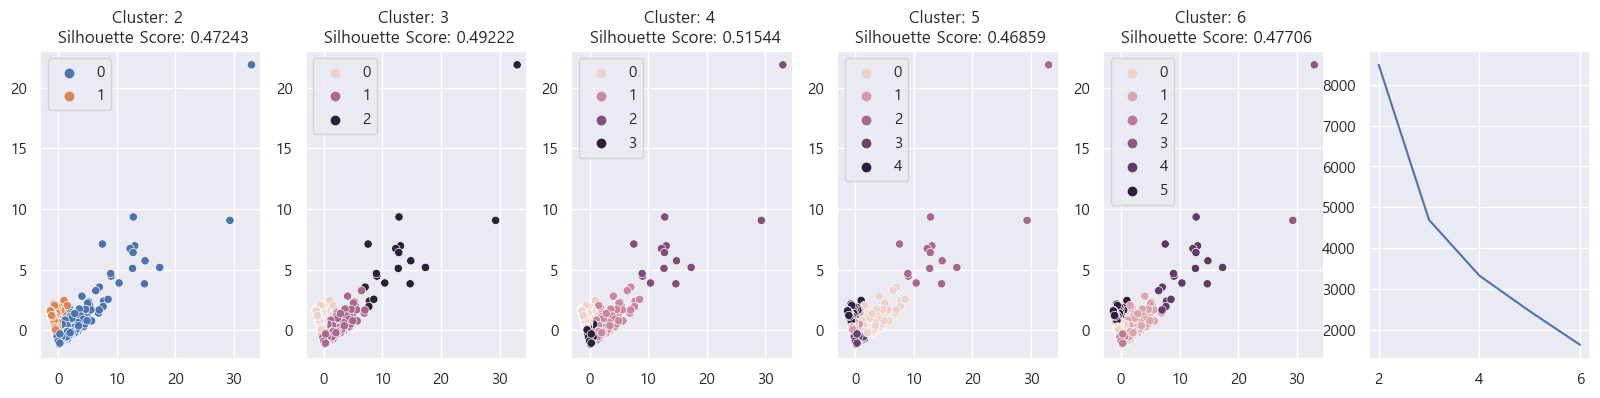

array([[ 4.08525768,  1.72732733],
       [-0.50764147,  0.13481882],
       [-0.13430722, -0.51533923],
       ...,
       [ 0.00882588, -0.87459037],
       [ 0.29108113, -1.05785619],
       [ 0.30099343, -0.30106684]])

In [39]:
scaler = StandardScaler()
rfm_scaler = scaler.fit_transform(rfm)
my_clustering(rfm_scaler)

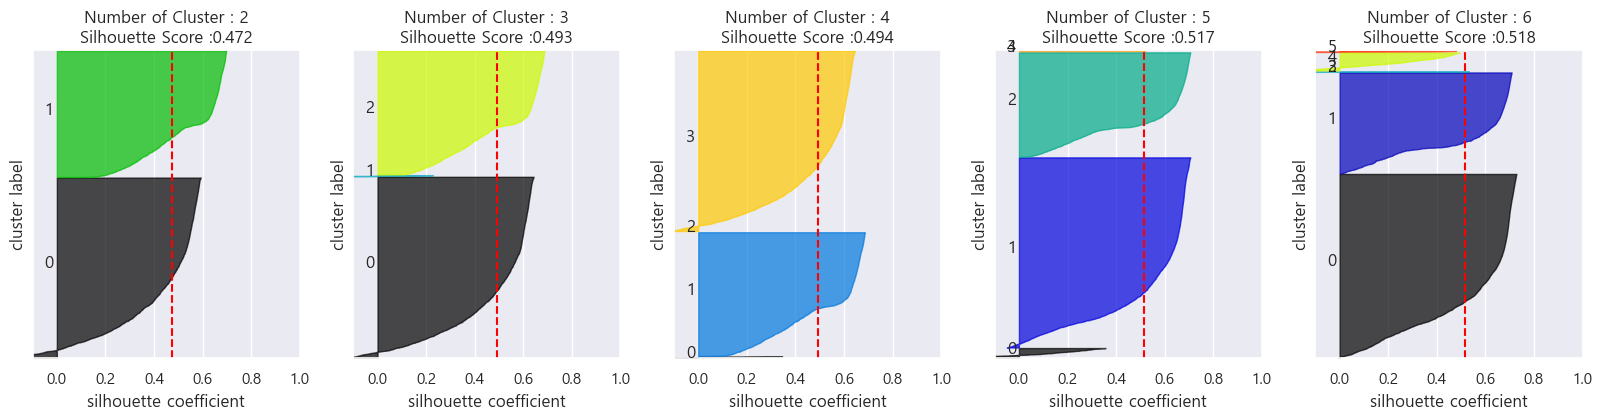

In [40]:
my_chart([2,3,4,5,6], rfm_scaler)

### 로그변환

explained_variance_ratio_ : [0.66425329 0.27195826] 0.94
2 실루엣 점수: 0.38901
2 inertia_ : 8036.92763
------------------------------------------------------------
3 실루엣 점수: 0.42042
3 inertia_ : 4935.13901
------------------------------------------------------------
4 실루엣 점수: 0.36286
4 inertia_ : 3466.74893
------------------------------------------------------------
5 실루엣 점수: 0.31530
5 inertia_ : 2897.96731
------------------------------------------------------------
6 실루엣 점수: 0.30822
6 inertia_ : 2421.35451
------------------------------------------------------------


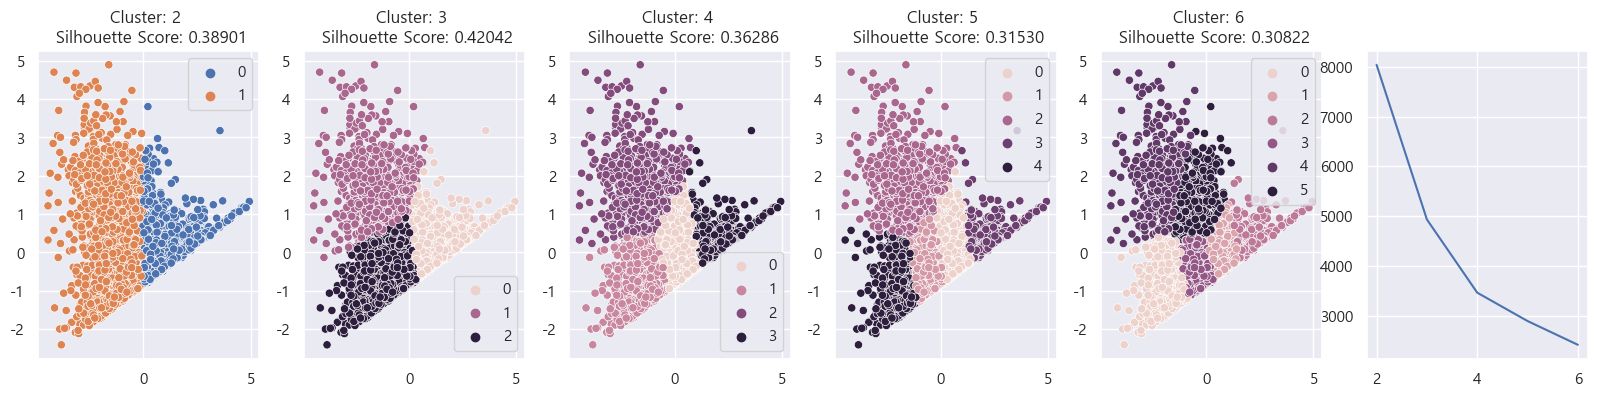

array([[ 2.20561477,  0.04634394],
       [-0.87677922, -0.46547983],
       [-0.31454403, -0.6618317 ],
       ...,
       [-0.76786872, -1.03413146],
       [ 0.57490321, -0.55652481],
       [ 1.41265606,  0.09154479]])

In [41]:
rfm['R'] =  np.log1p(rfm['R'])
rfm['F'] =  np.log1p(rfm['F'])
rfm['M'] =  np.log1p(rfm['M'])

rfm_log_scaler = scaler.fit_transform(rfm)
my_clustering(rfm_log_scaler)

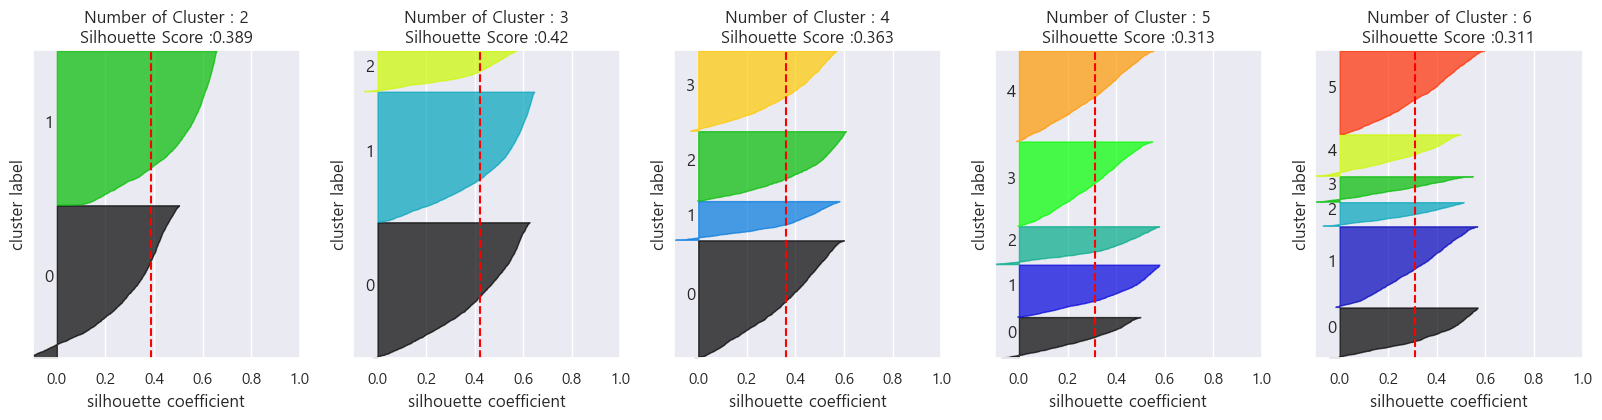

In [42]:
my_chart([2,3,4,5,6], rfm_log_scaler)

# 군집모델
* <font color=red><b>X : log 스케일링
* <font color=red><b>K=3 or K=4 군집
* <font color=red><b>my_clustering(rfm_log_scaler)

In [43]:
rfm_log_scaler[:5]

array([[ 0.73974151, -0.3173779 ,  3.24147324],
       [ 0.07239679, -0.84188813, -0.55473566],
       [ 0.4710543 , -0.62233158, -0.15276906],
       [ 0.40334992, -0.8003721 , -0.91005563],
       [ 0.74915673,  1.13355314,  1.69905838]])

## K=3

### 모델학습

explained_variance_ratio_ : [0.66425329 0.27195826] 0.94
3 실루엣 점수: 0.46730


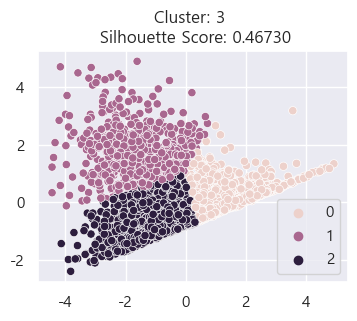

In [44]:
#------차원축소(PCA)------ 
pca = PCA(n_components=2, random_state=1234)
pca_X = pca.fit_transform(rfm_log_scaler)  
print(f"explained_variance_ratio_ : {pca.explained_variance_ratio_} {pca.explained_variance_ratio_.sum():.2f}")

#------KMeans군집화------ 
k = 3
model = KMeans(n_clusters=k, random_state=1234)
model.fit(pca_X)
pred = model.predict(pca_X)  #cluster_label
print(f"{k} 실루엣 점수: {silhouette_score(pca_X , pred):.5f}")

#------스케터차트------ 
plt.figure(figsize=(4,3))
sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=pred)
plt.title(f"Cluster: {k} \n Silhouette Score: {silhouette_score(pca_X , pred):.5f}" )
plt.show()

### 로그복원

In [45]:
dic = { 'cluster_label' : pred, 
        'R' : np.expm1(rfm['R']),
        'F' : np.expm1(rfm['F']),
        'M' : np.expm1(rfm['M']) }
temp = pd.DataFrame(dic)
temp['F_M'] = np.round((rfm['M'] / rfm['F']) * 100, 1)
temp.head()

,cluster_label,R,F,M,F_M
Customer ID,,,,,
12346,0,726.0,34.0,77556.46,316.7
12608,2,405.0,16.0,415.79,212.9
12745,2,574.0,22.0,723.85,210.0
12746,2,541.0,17.0,254.55,191.8
12747,0,732.0,257.0,9276.54,164.5


### 군집별 통계치

In [46]:
grp = temp.groupby('cluster_label').agg({'R': 'mean', 
                                    'F': 'mean', 
                                    'M': 'mean',
                                    'F_M' : 'mean' })
grp

,R,F,M,F_M
cluster_label,,,,
0,596.394980,275.777191,5756.671098,156.930207
1,67.801418,44.150355,640.847491,206.256170
2,489.167650,28.573715,504.612457,218.250253


In [47]:
grp.describe()

,R,F,M,F_M
count,3.000000,3.000000,3.000000,3.000000
mean,384.454683,116.167087,2300.710349,193.812210
std,279.421532,138.445646,2993.724857,32.498863
min,67.801418,28.573715,504.612457,156.930207
25%,278.484534,36.362035,572.729974,181.593189
50%,489.167650,44.150355,640.847491,206.256170
75%,542.781315,159.963773,3198.759294,212.253211
max,596.394980,275.777191,5756.671098,218.250253


## K = 4

### 모델학습

explained_variance_ratio_ : [0.66425329 0.27195826] 0.94
4 실루엣 점수: 0.42561


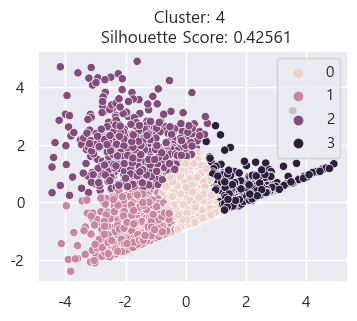

In [48]:
#------차원축소(PCA)------ 
pca = PCA(n_components=2, random_state=1234)
pca_X = pca.fit_transform(rfm_log_scaler)  
print(f"explained_variance_ratio_ : {pca.explained_variance_ratio_} {pca.explained_variance_ratio_.sum():.2f}")

#------KMeans군집화------ 
k = 4
model = KMeans(n_clusters=k, random_state=1234)
model.fit(pca_X)
pred = model.predict(pca_X)  #cluster_label
print(f"{k} 실루엣 점수: {silhouette_score(pca_X , pred):.5f}")

#------스케터차트------ 
plt.figure(figsize=(4,3))
sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=pred)
plt.title(f"Cluster: {k} \n Silhouette Score: {silhouette_score(pca_X , pred):.5f}" )
plt.show()

### 로그복원

In [49]:
dic = { 'cluster_label' : pred, 
        'R' : np.expm1(rfm['R']),
        'F' : np.expm1(rfm['F']),
        'M' : np.expm1(rfm['M']) }
temp = pd.DataFrame(dic)
temp['F_M'] = np.round((rfm['M'] / rfm['F']) * 100, 1)
temp.head()

,cluster_label,R,F,M,F_M
Customer ID,,,,,
12346,3,726.0,34.0,77556.46,316.7
12608,1,405.0,16.0,415.79,212.9
12745,0,574.0,22.0,723.85,210.0
12746,1,541.0,17.0,254.55,191.8
12747,3,732.0,257.0,9276.54,164.5


### 군집별 통계치

In [50]:
grp = temp.groupby('cluster_label').agg({'R': 'mean', 
                                    'F': 'mean', 
                                    'M': 'mean',
                                    'F_M' : 'mean' })
grp

,R,F,M,F_M
cluster_label,,,,
0,526.683260,77.517326,1279.964458,171.025134
1,474.385275,15.425304,276.730215,246.771909
2,64.846154,43.908284,632.607871,204.033284
3,633.623165,420.191680,9205.311461,151.985563


In [61]:
grp.describe(percentiles=[.34, .65])

,R,F,M,F_M
count,4.000000,4.000000,4.000000,4.000000
mean,424.884463,139.260648,2848.653501,193.453972
std,249.006529,188.998896,4258.072074,41.542773
min,64.846154,15.425304,276.730215,151.985563
34%,475.431235,44.580465,645.555003,171.685297
50%,500.534268,60.712805,956.286165,187.529209
65%,524.068361,75.836873,1247.596628,202.382877
max,633.623165,420.191680,9205.311461,246.771909


## 해당 군집 데이터 조회

In [67]:
idx = temp[temp['cluster_label'] ==3].index
df[df['Customer ID'].isin(idx)].head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,day_diff,monetary
InvoiceDate,,,,,,,,,
2009-12-01 09:06:00,489436,48173C,DOOR MAT BLACK FLOCK,10,5.95,13078,United Kingdom,739,59.50
2009-12-01 09:06:00,489436,21755,LOVE BUILDING BLOCK WORD,18,5.45,13078,United Kingdom,739,98.10
2009-12-01 09:06:00,489436,21754,HOME BUILDING BLOCK WORD,3,5.95,13078,United Kingdom,739,17.85
2009-12-01 09:06:00,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,13078,United Kingdom,739,27.04
2009-12-01 09:06:00,489436,22119,PEACE WOODEN BLOCK LETTERS,3,6.95,13078,United Kingdom,739,20.85


* VVIP 비율

In [73]:
(temp[temp['cluster_label']==3].shape[0] / temp.shape[0]) * 100

22.91588785046729